# Ring2D


# 1. Training

To contine the analysis below, you will have to train the neuralCT mode on Ring2D distribution. This can be done by the line of command:
```
python ./variationMain.py -source 0
```
Also, we have a trained model saving in the **demo** folder. So, in the following, we're going to assume using this saving. However, you can change this by change the **rootFolder** variable.

In [1]:
import numpy as np
import torch
from torch import nn
import flow
import source
import train
import utils
import math
import h5py

# Set gobal variables.

rootFolder = "./demo/variationModel_source_0_Shift_False_T_300_depthLevel_1_l8_M2_H128/"
device = torch.device("cpu")
dtype = torch.float

/Users/lili/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 2. Read from saving

In [2]:
# Load paremeters.

with h5py.File(rootFolder+"/parameter.hdf5","r") as f:
    numFlow = int(np.array(f["numFlow"]))
    lossPlotStep = int(np.array(f["lossPlotStep"]))
    hidden = int(np.array(f["hidden"]))
    nlayers = int(np.array(f["nlayers"]))
    nmlp = int(np.array(f["nmlp"]))
    lr = int(np.array(f["lr"]))
    batchSize = int(np.array(f["batchSize"]))
    epochs = int(np.array(f["epochs"]))
    K = int(np.array(f["K"]))

# Build the target.

target = source.Ring2d().to(device).to(dtype)
n = target.nvars[0]//2

# Rebuild the model.

def innerBuilder(num):
    maskList = []
    for i in range(nlayers):
        if i %2==0:
            b = torch.zeros(num)
            i = torch.randperm(b.numel()).narrow(0, 0, b.numel() // 2)
            b.zero_()[i] = 1
            b=b.reshape(1,num)
        else:
            b = 1-b
        maskList.append(b)
    maskList = torch.cat(maskList,0).to(torch.float32)
    fl = flow.RNVP(maskList, [utils.SimpleMLPreshape([num]+[hidden]*nmlp+[num],[nn.Softplus()]*nmlp+[None]) for _ in range(nlayers)], [utils.SimpleMLPreshape([num]+[hidden]*nmlp+[num],[nn.Softplus()]*nmlp+[utils.ScalableTanh(num)]) for _ in range(nlayers)])
    return fl
from utils import flowBuilder
f = flowBuilder(n,numFlow,innerBuilder,1).to(device).to(dtype)

# Load saving.

import os
import glob
name = max(glob.iglob(rootFolder+"savings/"+'*.saving'), key=os.path.getctime)
print("load saving at "+name)
saved = torch.load(name,map_location=device)
f.load(saved);

load saving at ./demo/variationModel_source_0_Shift_False_T_300_depthLevel_1_l8_M2_H128/savings/FlowNetSaving_epoch4990.saving


# 3. Analysis
Because this distribution is a ring, we presume the latent variables to be R and $\theta$. So, we plot the latent variable against calculated {R, $\theta$}.

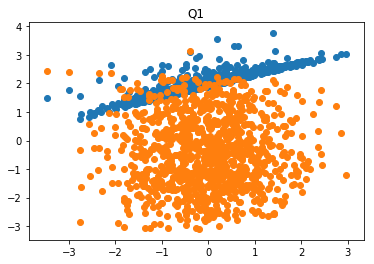

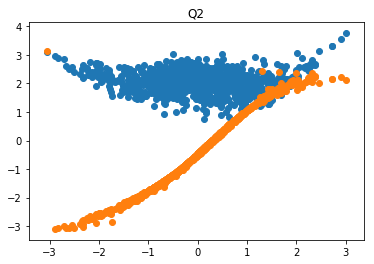

In [3]:
# Calculate modes in the latent space.

d0 = f.layerList[0].elements[:n]
d1 = f.layerList[0].elements[n:]
omega = (1/(torch.exp(d0+d1)))

# Plot these modes

from matplotlib import pyplot as plt
t =f.sample(1000)[0]

z = f.forward(t)[0].detach().numpy()
r = torch.sqrt(t[:,0]**2+t[:,1]**2).detach().numpy()
theta = torch.atan2(t[:,1],t[:,0]).detach().numpy()

plt.figure()
plt.scatter(z[:,0],r)
plt.scatter(z[:,0],theta)
plt.title("Q1")

plt.figure()
plt.scatter(z[:,1],r)
plt.scatter(z[:,1],theta)
plt.title("Q2")

plt.show()